## 3-Way ANOVA

The three-way ANOVA is an extension of the two-way ANOVA for assessing whether there is an interaction effect between three independent categorical variables on a continuous outcome variable.

We’ll use the **headache dataset** [datarium package], which contains the measures of migraine headache episode pain score in 72 participants treated with three different treatments. The participants include 36 males and 36 females. Males and females were further subdivided into whether they were at low or high risk of migraine.

We want to understand how each independent variable (type of treatments, risk of migraine and gender) interact to predict the pain score.

In [1]:
import pandas as pd
data = pd.read_csv('headache.csv')
print(data.shape)

(72, 5)


### Descriptive statistics

In [2]:
g = data.groupby(['gender', 'risk', 'treatment'])['pain_score']
ds = g.agg(n='count', mean='mean', sd='std', median='median', q1=lambda s: s.quantile(.25), q3=lambda s: s.quantile(.75), min='min', max='max')
ds['iqr'] = ds.q3 - ds.q1
ds['se'] = ds.sd / (ds.n ** 0.5)
ds['ci_low'] = ds['mean'] - (1.96 * ds.se)
ds['ci_high'] = ds['mean'] + (1.96 * ds.se)
ds.sort_index()

n       mean        sd     median         q1  \
gender risk treatment                                                 
female high X          6  78.865059  5.316489  81.055686  79.142521   
            Y          6  81.175304  4.619387  81.809575  80.011223   
            Z          6  81.035142  3.984886  80.842595  79.811669   
       low  X          6  74.156231  3.690272  74.624574  72.005373   
            Y          6  68.361925  4.081842  68.733945  65.236456   
            Z          6  69.779555  2.719645  69.587288  68.866039   
male   high X          6  92.738847  5.116095  93.392498  88.907525   
            Y          6  82.341542  5.000898  81.160483  78.951861   
            Z          6  79.680736  4.045885  80.370195  76.602057   
       low  X          6  76.051783  3.854876  75.947806  73.593322   
            Y          6  73.138772  4.765061  73.360982  69.455207   
            Z          6  74.455863  4.888865  74.850275  70.706772   

                              q3        min         max       iqr        se  \
gender risk treatment                                                         
female high X          81.431621  68.360185   82.657063  2.289099  2.170447   
            Y          83.666457  73.144392   86.591089  3.655234  1.885857   
            Z          82.406134  74.988057   87.142265  2.594465  1.626823   
       low  X          77.059079  68.613936   78.071412  5.053705  1.506547   
            Y          69.799297  63.732617   74.746005  4.562841  1.666405   
            Z          71.645371  65.449408   73.096326  2.779333  1.110290   
male   high X          95.304508  86.293706  100.000000  6.396984  2.088637   
            Y          83.897360  77.524462   91.178517  4.945499  2.041608   
            Z          81.983814  74.419865   85.056463  5.381757  1.651725   
       low  X          78.694621  70.832421   81.163944  5.101299  1.573747   
            Y          74.857744  67.923560   80.677163  5.402536  1.945328   
            Z          77.945192  68.299416   80.432775  7.238420  1.995871   

                          ci_low    ci_high  
gender risk treatment                        
female high X          74.610982  83.119135  
            Y          77.479024  84.871583  
            Z          77.846569  84.223715  
       low  X          71.203398  77.109063  
            Y          65.095771  71.628079  
            Z          67.603386  71.955725  
male   high X          88.645119  96.832575  
            Y          78.339990  86.343094  
            Z          76.443354  82.918118  
       low  X          72.967240  79.136326  
            Y          69.325930  76.951615  
            Z          70.543956  78.367769

### Assumptions

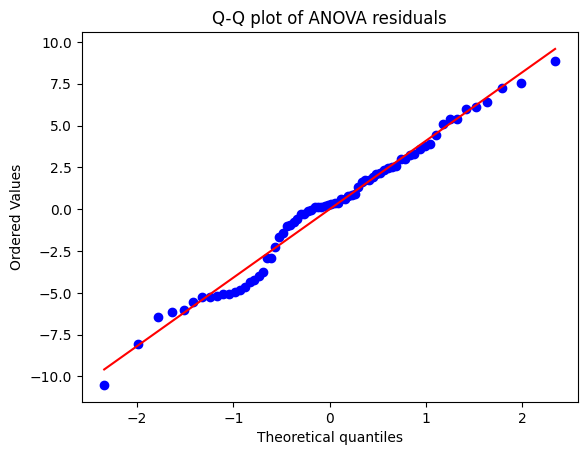

ShapiroResult(statistic=np.float64(0.9821218558347028), pvalue=np.float64(0.39807840029779584))
LeveneResult(statistic=np.float64(0.17859528084995452), pvalue=np.float64(0.9982136500456728))


In [3]:
import matplotlib.pyplot as plt
import scipy.stats as ss
import statsmodels.formula.api as smf
m = smf.ols("pain_score ~ C(gender)*C(risk)*C(treatment)", data=data).fit()
ss.probplot(m.resid, dist="norm", plot=plt)
plt.title("Q-Q plot of ANOVA residuals")
plt.show()
print(ss.shapiro(m.resid)) # plot looks good and even shapiro-wilk test returns p-value ~0.4 so the data is normal 

cells = data.groupby(['gender','risk','treatment'])['pain_score'].apply(list)
print(ss.levene(*cells, center='median')) # p-value ~1 -> homogenous variance

#### Outliers

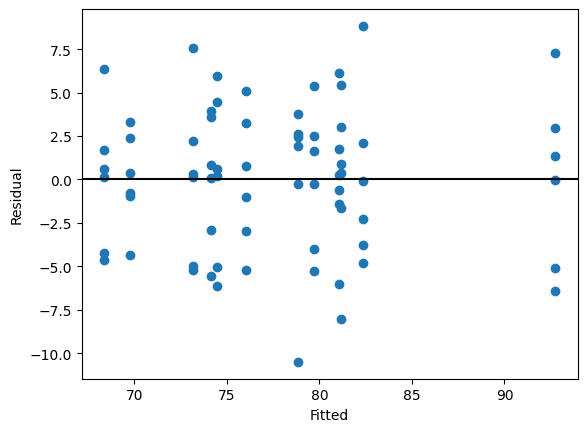

,standard_resid,student_resid,cooks_d
56,-2.616140,-2.756206,0.114070
28,2.200766,2.276150,0.080723
61,-2.000023,-2.052898,0.066668
7,1.877365,1.918867,0.058742
19,1.808322,1.844147,0.054500
22,-1.605102,-1.626984,0.042939
45,1.589895,1.610888,0.042129
13,-1.533205,-1.551063,0.039179
70,1.520922,1.538136,0.038553
66,-1.505970,-1.522417,0.037799


In [4]:
plt.scatter(m.fittedvalues, m.resid)
plt.axhline(0, color="k")
plt.xlabel("Fitted")
plt.ylabel("Residual")
plt.show()
from statsmodels.stats.outliers_influence import OLSInfluence
infl = OLSInfluence(m)
out = infl.summary_frame() 
out[['standard_resid','student_resid','cooks_d']].sort_values('cooks_d', ascending=False).head(10)
# no |student_resid| > 3 -> no outliers  

#### Normality

In [5]:
# taken care of in "Assumptions" above

#### Homogeneity of variance

In [6]:
# taken care of in "Assumptions" above

### Anova

In [7]:
from statsmodels.stats.anova import anova_lm
anova_lm(m, typ=3) # 3-way interaction is significant, wwe will consider conditional effects

,sum_sq,df,F,PR(>F)
Intercept,37318.184764,1.0,1928.766332,2.538132e-47
C(gender),577.446016,1.0,29.844925,9.483691e-07
C(risk),66.519182,1.0,3.438001,6.862955e-02
C(treatment),20.132278,2.0,0.520262,5.970215e-01
C(gender):C(risk),215.217212,1.0,11.123363,1.466050e-03
C(gender):C(treatment),399.733382,2.0,10.329981,1.395716e-04
C(risk):C(treatment),110.970499,2.0,2.867719,6.464732e-02
C(gender):C(risk):C(treatment),286.595625,2.0,7.406255,1.334476e-03
Residual,1160.892871,60.0,NaN,NaN


### Post-hoc tests

If there is a significant 3-way interaction effect, you can decompose it into:

-    Simple two-way interaction: run two-way interaction at each level of third variable,
-    Simple simple main effect: run one-way model at each level of second variable,
-    Simple simple pairwise comparisons: run pairwise or other post-hoc comparisons if necessary.

If you do not have a statistically significant three-way interaction, you need to determine whether you have any statistically significant two-way interaction from the ANOVA output. You can follow up a significant two-way interaction by simple main effects analyses and pairwise comparisons between groups if necessary.


#### Two-way interactions

In [8]:
# with a significant 3-way interaction, each 2-way interaction is conditional on the 3rd factor
# so we test each 2-way interaction *within* each level of the 3rd variable.

def _simple_two_way(data_subset, formula, interaction_term, label):
    mod = smf.ols(formula, data=data_subset).fit()
    aov = anova_lm(mod, typ=3)
    p = aov.loc[interaction_term, 'PR(>F)']
    print(f"{label}: {interaction_term} p = {p:.4g}")
    display(aov)
    return p

# 1) gender × risk, separately for each treatment level
for t in sorted(data['treatment'].unique()):
    sub = data.loc[data['treatment'] == t].copy()
    _simple_two_way(
        sub,
        "pain_score ~ C(gender)*C(risk)",
        "C(gender):C(risk)",
        label=f"Within treatment={t}",
    )

# 2) gender × treatment, separately for each risk level
for r in sorted(data['risk'].unique()):
    sub = data.loc[data['risk'] == r].copy()
    _simple_two_way(
        sub,
        "pain_score ~ C(gender)*C(treatment)",
        "C(gender):C(treatment)",
        label=f"Within risk={r}",
    )

# 3) risk × treatment, separately for each gender level
for g in sorted(data['gender'].unique()):
    sub = data.loc[data['gender'] == g].copy()
    _simple_two_way(
        sub,
        "pain_score ~ C(risk)*C(treatment)",
        "C(risk):C(treatment)",
        label=f"Within gender={g}",
    )

Within treatment=X: C(gender):C(risk) p = 0.004274


,sum_sq,df,F,PR(>F)
Intercept,37318.184764,1.0,1800.252865,4.541104e-21
C(gender),577.446016,1.0,27.856361,3.640480e-05
C(risk),66.519182,1.0,3.208927,8.838384e-02
C(gender):C(risk),215.217212,1.0,10.382215,4.274481e-03
Residual,414.588256,20.0,NaN,NaN


Within treatment=Y: C(gender):C(risk) p = 0.3508


,sum_sq,df,F,PR(>F)
Intercept,39536.579469,1.0,1845.025912,3.561044e-21
C(gender),4.080335,1.0,0.190414,6.672464e-01
C(risk),492.547990,1.0,22.985393,1.104515e-04
C(gender):C(risk),19.554744,1.0,0.912548,3.508443e-01
Residual,428.574788,20.0,NaN,NaN


Within treatment=Z: C(gender):C(risk) p = 0.07868


,sum_sq,df,F,PR(>F)
Intercept,39400.165336,1.0,2480.104915,1.898022e-22
C(gender),5.503246,1.0,0.346410,5.627409e-01
C(risk),380.064683,1.0,23.923765,8.830056e-05
C(gender):C(risk),54.554253,1.0,3.434003,7.868063e-02
Residual,317.729827,20.0,NaN,NaN


Within risk=high: C(gender):C(treatment) p = 0.0008597


,sum_sq,df,F,PR(>F)
Intercept,37318.184764,1.0,1683.075465,6.509194e-28
C(gender),577.446016,1.0,26.043207,1.740421e-05
C(treatment),20.132278,2.0,0.453990,6.393808e-01
C(gender):C(treatment),399.733382,2.0,9.014123,8.597413e-04
Residual,665.178458,30.0,NaN,NaN


Within risk=low: C(gender):C(treatment) p = 0.6201


,sum_sq,df,F,PR(>F)
Intercept,32994.879212,1.0,1996.807738,5.217062e-29
C(gender),10.779355,1.0,0.652353,4.256309e-01
C(treatment),109.477870,2.0,3.312730,5.012709e-02
C(gender):C(treatment),16.044566,2.0,0.485498,6.201420e-01
Residual,495.714413,30.0,NaN,NaN


Within gender=female: C(risk):C(treatment) p = 0.05378


,sum_sq,df,F,PR(>F)
Intercept,37318.184764,1.0,2170.521906,1.518755e-29
C(risk),66.519182,1.0,3.868927,5.849696e-02
C(treatment),20.132278,2.0,0.585473,5.630789e-01
C(risk):C(treatment),110.970499,2.0,3.227165,5.377519e-02
Residual,515.795551,30.0,NaN,NaN


Within gender=male: C(risk):C(treatment) p = 0.01644


,sum_sq,df,F,PR(>F)
Intercept,51602.962433,1.0,2399.775699,3.432538e-30
C(risk),835.374326,1.0,38.848758,7.285360e-07
C(treatment),571.396212,2.0,13.286279,7.374482e-05
C(risk):C(treatment),203.220142,2.0,4.725337,1.644381e-02
Residual,645.097320,30.0,NaN,NaN


#### Main effects

In [9]:
# Simple-simple main effects: test the effect of one factor at each combination of the other two.

def _one_way(data_subset, formula):
    mod = smf.ols(formula, data=data_subset).fit()
    aov = anova_lm(mod, typ=2)
    p = aov.iloc[0]['PR(>F)']
    return p, aov

rows = []

# A) Treatment effect within each (gender, risk) cell
for g in sorted(data['gender'].unique()):
    for r in sorted(data['risk'].unique()):
        sub = data.loc[(data['gender'] == g) & (data['risk'] == r)].copy()
        p, aov = _one_way(sub, "pain_score ~ C(treatment)")
        rows.append({"effect": "treatment", "within": f"gender={g}, risk={r}", "p": p})

# B) Risk effect within each (gender, treatment) cell
for g in sorted(data['gender'].unique()):
    for t in sorted(data['treatment'].unique()):
        sub = data.loc[(data['gender'] == g) & (data['treatment'] == t)].copy()
        p, aov = _one_way(sub, "pain_score ~ C(risk)")
        rows.append({"effect": "risk", "within": f"gender={g}, treatment={t}", "p": p})

# C) Gender effect within each (risk, treatment) cell
for r in sorted(data['risk'].unique()):
    for t in sorted(data['treatment'].unique()):
        sub = data.loc[(data['risk'] == r) & (data['treatment'] == t)].copy()
        p, aov = _one_way(sub, "pain_score ~ C(gender)")
        rows.append({"effect": "gender", "within": f"risk={r}, treatment={t}", "p": p})
simple_effects = pd.DataFrame(rows).sort_values(["effect", "p"])
display(simple_effects)

,effect,within,p
10,gender,"risk=high, treatment=X",0.000971
15,gender,"risk=low, treatment=Z",0.067791
14,gender,"risk=low, treatment=Y",0.091778
13,gender,"risk=low, treatment=X",0.404662
12,gender,"risk=high, treatment=Z",0.572021
11,gender,"risk=high, treatment=Y",0.683641
7,risk,"gender=male, treatment=X",0.000080
6,risk,"gender=female, treatment=Z",0.000194
5,risk,"gender=female, treatment=Y",0.000470
8,risk,"gender=male, treatment=Y",0.008525


#### Pairwise comparisons

In [10]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd

alpha = 0.05
def tukey_in_slice(df, dv, factor, slice_label=""):
    # df: already-filtered slice
    levels = df[factor].dropna().unique()
    if len(levels) < 2:
        print(f"Skip (need >=2 levels): {factor} {slice_label}")
        return None

    res = pairwise_tukeyhsd(endog=df[dv], groups=df[factor], alpha=alpha)
    tbl = pd.DataFrame(res.summary().data[1:], columns=res.summary().data[0])

    header = f"Tukey HSD: {factor} {slice_label} (alpha={alpha})"
    print(header)
    display(tbl)
    return tbl

# 1) Treatment pairwise comparisons within each (gender, risk)
for gender in sorted(data["gender"].unique()):
    for risk in sorted(data["risk"].unique()):
        sub = data[(data["gender"] == gender) & (data["risk"] == risk)].copy()
        tukey_in_slice(sub, dv="pain_score", factor="treatment",
                       slice_label=f"within gender={gender}, risk={risk}")

# 2) Risk (2 levels) within each (gender, treatment)
for gender in sorted(data["gender"].unique()):
    for treatment in sorted(data["treatment"].unique()):
        sub = data[(data["gender"] == gender) & (data["treatment"] == treatment)].copy()
        tukey_in_slice(sub, dv="pain_score", factor="risk",
                       slice_label=f"within gender={gender}, treatment={treatment}")

# 3) Gender (2 levels) within each (risk, treatment)
for risk in sorted(data["risk"].unique()):
    for treatment in sorted(data["treatment"].unique()):
        sub = data[(data["risk"] == risk) & (data["treatment"] == treatment)].copy()
        tukey_in_slice(sub, dv="pain_score", factor="gender",
                       slice_label=f"within risk={risk}, treatment={treatment}")

Tukey HSD: treatment within gender=female, risk=high (alpha=0.05)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,X,Y,2.3102,0.6748,-4.6961,9.3166,False
1,X,Z,2.1701,0.7060,-4.8363,9.1765,False
2,Y,Z,-0.1402,0.9985,-7.1465,6.8662,False


Tukey HSD: treatment within gender=female, risk=low (alpha=0.05)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,X,Y,-5.7943,0.0319,-11.1088,-0.4798,True
1,X,Z,-4.3767,0.1153,-9.6912,0.9378,False
2,Y,Z,1.4176,0.7712,-3.8969,6.7321,False


Tukey HSD: treatment within gender=male, risk=high (alpha=0.05)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,X,Y,-10.3973,0.0047,-17.5135,-3.2811,True
1,X,Z,-13.0581,0.0007,-20.1743,-5.9419,True
2,Y,Z,-2.6608,0.6054,-9.7770,4.4554,False


Tukey HSD: treatment within gender=male, risk=low (alpha=0.05)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,X,Y,-2.9130,0.5201,-9.7011,3.8751,False
1,X,Z,-1.5959,0.8166,-8.3840,5.1922,False
2,Y,Z,1.3171,0.8705,-5.4710,8.1052,False


Tukey HSD: risk within gender=female, treatment=X (alpha=0.05)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,high,low,-4.7088,0.105,-10.5957,1.1781,False


Tukey HSD: risk within gender=female, treatment=Y (alpha=0.05)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,high,low,-12.8134,0.0005,-18.4208,-7.206,True


Tukey HSD: risk within gender=female, treatment=Z (alpha=0.05)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,high,low,-11.2556,0.0002,-15.6441,-6.8671,True


Tukey HSD: risk within gender=male, treatment=X (alpha=0.05)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,high,low,-16.6871,0.0001,-22.514,-10.8601,True


Tukey HSD: risk within gender=male, treatment=Y (alpha=0.05)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,high,low,-9.2028,0.0085,-15.4861,-2.9194,True


Tukey HSD: risk within gender=male, treatment=Z (alpha=0.05)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,high,low,-5.2249,0.0714,-10.9973,0.5476,False


Tukey HSD: gender within risk=high, treatment=X (alpha=0.05)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,female,male,13.8738,0.001,7.1622,20.5854,True


Tukey HSD: gender within risk=high, treatment=Y (alpha=0.05)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,female,male,1.1662,0.6836,-5.0265,7.3589,False


Tukey HSD: gender within risk=high, treatment=Z (alpha=0.05)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,female,male,-1.3544,0.572,-6.52,3.8112,False


Tukey HSD: gender within risk=low, treatment=X (alpha=0.05)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,female,male,1.8956,0.4047,-2.9587,6.7498,False


Tukey HSD: gender within risk=low, treatment=Y (alpha=0.05)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,female,male,4.7768,0.0918,-0.9305,10.4842,False


Tukey HSD: gender within risk=low, treatment=Z (alpha=0.05)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,female,male,4.6763,0.0678,-0.4126,9.7652,False


### Interaction visualisation

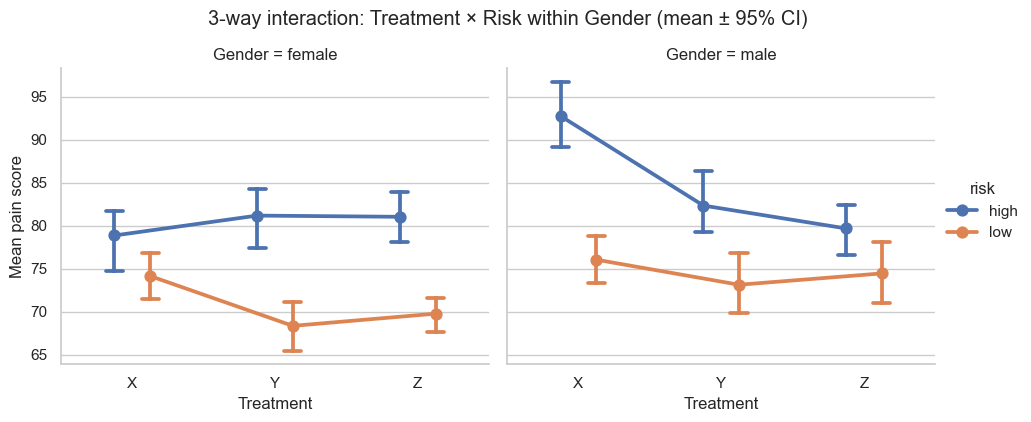

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
df = data.copy()
treatment_order = sorted(df["treatment"].dropna().unique())
risk_order = sorted(df["risk"].dropna().unique())
gender_order = sorted(df["gender"].dropna().unique())
sns.set_theme(style="whitegrid")
# Facet by gender, show risk as lines, treatment on x-axis (mean ± 95% CI)
g = sns.catplot(
    data=df,
    x="treatment",
    y="pain_score",
    hue="risk",
    col="gender",
    kind="point",
    order=treatment_order,
    hue_order=risk_order,
    col_order=gender_order,
    errorbar=("ci", 95),   # seaborn >= 0.12
    dodge=0.25,
    capsize=0.12,
    height=4,
    aspect=1.2,
)

g.set_axis_labels("Treatment", "Mean pain score")
g.set_titles("Gender = {col_name}")
g.fig.suptitle(
    "3-way interaction: Treatment × Risk within Gender (mean ± 95% CI)",
    y=1.05
)
plt.show()


### Interpretation

There is a significant gender × risk × treatment interaction on pain score. Follow-up simple-effects analyses show treatment differences are present mainly for high-risk males (X < Y and X < Z) and low-risk females (X < Y), with no detectable treatment differences in the other gender×risk slices.